In [1]:
from __future__ import division
import os
os.sys.path.append("/home/izmailovpavel/Documents/Projects/pristine-ml/")

from oil.lazy.lazy_matrix import LazyMatrix, Lazy
from oil.lazy.lazy_types import LazyAvg
from oil.utils.utils import reusable
from oil.lazy.linalg.VRmethods import GradLoader, oja_grad2,SGHA_grad2,SGD,SVRG, SGHA_grad,oja_subspace_grad
from oil.logging.lazyLogger import LazyLogger

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import time
import pandas as pd

In [3]:
Lazy(np.zeros((10,10))).__truediv__

<bound method LazyMatrix.__truediv__ of <oil.lazy.lazy_matrix.Lazy object at 0x7fc034fb8518>>

## VR-PCA

In [4]:
## Toy Dataset setup for PCA
def PCA_dataset(n=10**5,rank=100,float_type=np.float64):
    toy_eigs2 = np.random.rand(rank)**2
    toy_eigs2[:30] += np.linspace(0,1,30)#np.array([1.0,.95,.7,.5,.3,.01,.001,-.4,-.7,-.94])
    toy_eigs2 = np.sort(toy_eigs2)[::-1]
    S = np.diag(toy_eigs2).astype(float_type)
    U = np.random.randn(n,rank).astype(float_type)
    U,_ = np.linalg.qr(U)
    V = np.random.randn(rank,rank).astype(float_type)
    V,_ = np.linalg.qr(V)
    X = (np.sqrt(n)*U@S@V.T).astype(float_type)
    A = X.T@X/n
    return X,V,A

def cov_gen(X,bs=1000):
    def _gen():
        n = X.shape[0]
        indices = np.random.permutation(n).reshape(n//bs,bs)
        for batch_ids in indices:
            x = X[batch_ids]
            yield Lazy(x.T)@Lazy(x)/bs
    return reusable(_gen)

In [5]:
n=10**5; rank = 100; float_type = np.float64
X,V,A_full = PCA_dataset(n,rank,float_type)

# Create a Lazy Average from iterable of minibatches
A = LazyAvg(cov_gen(X))
grads = GradLoader(oja_grad2,[A])

In [6]:
# Setup code for logging
logger = LazyLogger(**{'no_print':True, 'minPeriod':0, 'timeFrac':1})
logger.i = 0 # annoying but we will add some temporary state to keep track of step
sin_pair = lambda u, w: 1-((u@w)**2 /((w@w)*(u@u)))
def log(w,lr,grad):
    logger.i+=1
    with logger as do_log:
        if do_log:
            wallclocktime = time.time()
            metrics = {}
            metrics[r"$||\nabla L(w)||$"] = np.linalg.norm(grad)
            metrics[r"$|\sin^2\measuredangle(v,w)|$"] = sin_pair(w,V[:,0])
            logger.add_scalars('metrics',metrics,step=logger.i)

In [11]:
w0 = np.random.randn(rank).astype(float_type)
w0 /= np.linalg.norm(w0)
lr = lambda e: .01#*cosLr(num_epochs)(e)
num_epochs = 30
logger.scalar_frame=pd.DataFrame()
w = SVRG(grads,w0,lr,num_epochs,log)

<Figure size 432x288 with 0 Axes>

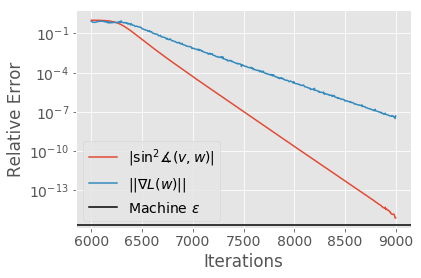

In [12]:
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 14})
f = plt.figure()
logger.scalar_frame.plot(logy=True)
plt.axhline(y=np.finfo(float_type).eps,label = r"Machine $\epsilon$",color='k')
plt.ylabel('Relative Error')
plt.xlabel("Iterations")
plt.legend()
f.savefig("VR_PCA.pdf", bbox_inches='tight')

## VR-GPCA

In [13]:
## Toy Dataset setup for GPCA
def GPCA_dataset(n=10**5,rank=100,float_type=np.float64):
    # Construct B matrix
    ideal_diag = np.diag(np.random.rand(rank))#np.abs(np.eye(rank))
    R = np.random.randn(rank,rank)
    R,_ = np.linalg.qr(R)
    B_ideal = R.T@ideal_diag@R
    # Get Y fron n samples from underlying distribution N(0,B_ideal)
    Y = np.random.multivariate_normal(np.zeros(rank),B_ideal,n).astype(float_type)
    B = Y.T@Y/n
    
    # Construct A from generalized SVD
    toy_eigs3 = np.random.rand(rank)**2
    toy_eigs3[:30] += np.linspace(0,1,30)
    toy_eigs3 = np.sort(toy_eigs3)[::-1]
    
    S = np.diag(toy_eigs3)
    U = np.random.randn(n,rank)
    U,_ = np.linalg.qr(U)
    V = np.random.randn(rank,rank)
    V,_ = np.linalg.qr(V)
    invSqrtB = sp.linalg.fractional_matrix_power(B,-1/2)
    V = invSqrtB@V # So that V.T@B@V = I (B orthogonal)
    X = (np.sqrt(n)*U@S@(B@V).T).astype(float_type)
    A = X.T@X/n
    
#     # Extract out top generalized eigenvector
#     index = toy_eigs3.argmax()
#     v = V.T[index].astype(float_type)
#     v = v/np.sqrt(v@B@v)
    return X,Y,V,A,B

In [14]:
n = 10**6; rank = 100; float_type=np.float64
X,Y,V,A_full,B_full = GPCA_dataset(n,rank,float_type)
A = LazyAvg(cov_gen(X,bs=10**3))
B = LazyAvg(cov_gen(Y,bs=10**3))
grads2 = GradLoader(SGHA_grad,(A,B))

In [15]:
# Setup code for logging
logger = LazyLogger(**{'no_print':True, 'minPeriod':0, 'timeFrac':1})
logger.i = 0 # annoying but we will add some temporary state to keep track of step
#sin_pair = lambda u, w: 1-((u@B@w)**2 /((w@B@w)*(u@B@u)))
sin_pair = lambda u, w: 1-((u@w)**2 /((w@w)*(u@u)))
def log(w,lr,grad):
    logger.i+=1
    with logger as do_log:
        if do_log:
            wallclocktime = time.time()
            metrics = {}
            metrics[r"$||\nabla L(w)||$"] = np.linalg.norm(grad)
            metrics[r"$|\sin^2\measuredangle(v,w)|$"] = sin_pair(w,V[:,0])
            logger.add_scalars('metrics',metrics,step=logger.i)

In [16]:
w0 = np.random.randn(rank).astype(float_type)
w0 /= np.linalg.norm(w0)
lr = lambda e: .5#*cosLr(num_epochs)(e)
num_epochs = 75
logger.scalar_frame=pd.DataFrame()
w = SVRG(grads2,w0,lr,num_epochs,log)

KeyboardInterrupt: 

In [ ]:
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 14})
f = plt.figure()
logger.scalar_frame.plot(logy=True)
plt.axhline(y=np.finfo(float_type).eps,label = r"Machine $\epsilon$",color='k')
plt.ylabel('Relative Error')
plt.xlabel("Iterations")
plt.legend()
f.savefig("VR_GPCA.pdf", bbox_inches='tight')

In [ ]:
len(logger.scalar_frame)

## Block VR-PCA (k=10)

In [31]:
n=10**5; rank = 100; float_type = np.float64
X,V,A_full = PCA_dataset(n,rank,float_type)
k = 10 # block size
# Create a Lazy Average from iterable of minibatches
A = LazyAvg(cov_gen(X))
grads = GradLoader(oja_subspace_grad,[A])

In [32]:
# Setup code for logging
logger = LazyLogger(**{'no_print':True, 'minPeriod':0, 'timeFrac':1})
logger.i = 0 # annoying but we will add some temporary state to keep track of step
VVT = V[:,:k]@V[:,:k].T
def log(W,lr,grad):
    logger.i+=1
    with logger as do_log:
        if do_log:
            wallclocktime = time.time()
            metrics = {}
            metrics[r"$||\nabla L(W)||_F$"] = np.linalg.norm(grad,ord='fro')
            metrics[r"$||VV^T - WW^T||_F$"] = np.linalg.norm(VVT - W@W.T,ord='fro')
            logger.add_scalars('metrics',metrics,step=logger.i)

In [33]:
W0 = np.random.randn(rank,k).astype(float_type)
W0, _ =  np.linalg.qr(W0) #orthogonalize the matrix
lr = lambda e: .1#*cosLr(num_epochs)(e)
num_epochs = 150
W = SVRG(grads,W0,lr,num_epochs,log)

<Figure size 432x288 with 0 Axes>

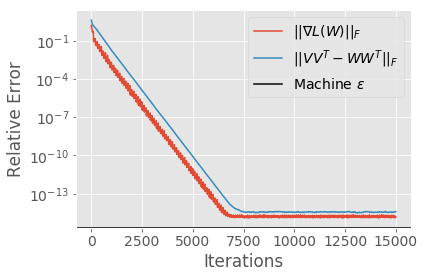

In [34]:
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 14})
f = plt.figure()
logger.scalar_frame.plot(logy=True)
plt.axhline(y=np.finfo(float_type).eps,label = r"Machine $\epsilon$",color='k')
plt.ylabel('Relative Error')
plt.xlabel("Iterations")
plt.legend()
f.savefig("VR_GPCA_subspace.pdf", bbox_inches='tight')

## Block VR-GPCA (k=10)

In [17]:
import numpy as np
import torch
np.random.rand(10,5).sqrt()

AttributeError: 'numpy.ndarray' object has no attribute 'sqrt'

In [25]:
torch.sqrt(torch.rand(10).cuda()@torch.rand(10).cuda())

tensor(1.2981, device='cuda:0')

In [15]:
torch.normal(10)

TypeError: normal(): argument 'mean' (position 1) must be Tensor, not int

In [20]:
np.sqrt(np.random.rand(10)@np.ones(10))

2.2786547960468644

In [27]:
for i in range(10):
    print(i)
    if i==2: break

0
1
2
